# HSC transfer learning code pytorch version

앞부분의 옵션만 바꾸면 그에 따라 학습을 진행할 수 있게 짜놓았습니다.

HCP 7개의 task에 따라 대체로 비슷하나, 마지막 output class가 2개냐 혹은 그 이상이냐에 따라 나뉘어져 있는 부분이 많습니다.

In [1]:
import os
import os.path as pth
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from torchsummary import summary
from datetime import datetime as dt
from pytz import timezone
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from IPython.display import clear_output
import random

tz = timezone('Asia/Seoul')

plt.rcParams.update({'font.size': 16})



## Set parameter

In [302]:
config = {
    ### 몇 번째 GPU를 사용할 지를 지정합니다. CLI에 nvidia-smi 치면 나오는 0부터 시작하는 숫자입니다
    'gpu_num': 1,
    
    ### 이번 트레이닝에 타겟으로 사용할 태스크를 지정합니다.
    'target_task': 1,
    'task_list': ['WM', 'MOTOR', 'EMOTION', 'RELATIONAL', 'SOCIAL', 'LANGUAGE', 'GAMBLING'],
    'classes_for_task' : [8,5,2,2,2,2,2],
    'output_size' : 0, #output size는 아래 블록에서 task에 따라 맞게 지정됩니다.
    
    ### input을 sample 단위로 z-score normalization을 할 지 지정합니다.
    ### 데이터 자체에 이미 z-scoring이 되어있다고 하여 따로 사용하지는 않고 있습니다
    'is_zscore':False,
    
    ### training, test에 사용할 서브젝트 숫자를 지정합니다.
    ### 모든 training, test 데이터를 사용하려면 2000으로 놓으시면 됩니다.
    'train_n_subject': 2000,
    'test_n_subject': 2000,

    
    ### HSC 파라미터를 지정합니다.
    ### Sparsity control 없이 하시려면 target_h와 maxb를 아래와 같이 세팅하시면 됩니다.
    'hsc':{
        'target_h': [None],
        'max_b': [0.5, 1.5],
        'b_lr': [0.05, 0.15], #3*1e-5
        'l2': 5*1e-4, 
        'l1': None,
        'patience':1,
    },
    
    ### 모델의 디테일을 지정합니다
    ### comb_num은 fully connected layer의 조합을 의미합니다
    ### base_channel, kernel_size, padding, stride과 같은 파라미터는 현재는 쓰이지 않으나, 
    ### 차후에 3D CNN으로의 확장성을 염두에 두어 legacy로 남겨두었습니다. 
    'comb':{
        'comb_num': (5000,1000,),
        'base_channel': None,
        'kernel_size': None,
        'padding':None,
        'stride': None,
    },
    'pool':{
        'type': None,
        'size': None,
        'stride': None,
        'padding': None,
    },
    'fc':{
        'fc_num': None,
     },

    ### 원래는 convolution block 이후 출력과 어떻게 연결할 지를 지정할 때 쓰는 파라미터이나,
    ### 이 또한 차후 3D CNN으로의 확장성을 염두에 두어 legacy로 남겨두었습니다.
    'between_type': None,
    
    ### Activation function을 지정하는 부분입니다.
    'activation':'relu',

    ### batchnorm, dropout에 대한 부분입니다.
    ### 만약 droupout을 0으로 지정한다면, 드랍아웃을 안 쓰는 것과 동일합니다.
    'is_batchnorm': False,
    'dropout_rate': 0.5,
    
    ### batch size를 지정하는 부분입니다.
    'batch_size': 512,
    
    ### 에폭, 러닝 레이트 등을 지정하는 부분입니다.
    'num_epoch': 2000, #300,
    'learning_rate': 1e-6, #1e-3,

    ### generalization 효과를 높이기 위해 repitition을 하는데, 
    ### 최대치는 여기서 1000번으로 넉넉하게 지정해놓고, 
    ### 위 REPEAT_START-END 형태로 조절하는 식으로 사용합니다.
    'num_fold': 3, #5
    'num_repeat_of_fold': 1000,
    'num_n_sbj_repeat': 1000,

    ### warmup_epoch은 finetune 태스크에서, 처음 몇 에폭은 fixed case로 학습을 진행하는 것을 의미합니다
    ### 이는 일반적으로 transfer learning에서 학습을 안정화 시키는 효과가 있다고 알려져 있어 사용합니다
    'warmup_epoch':0,

    
    ### 시간을 줄이기 위해 training learning curve가 일정 수렴이 발생하면 훈련을 중단하도록 하였습니다.
    'es_patience': 100,
    'lr_patience':5,
    'lr_anneal_rate':0.997,
    
    ### 재현성을 위해 시드를 고정합니다. 
    ### sklearn 5 fold 함수 등에서 사용할 랜덤 시드입니다.
    'random_state': 7777,
}

In [303]:
target_task_list = [config['task_list'][config['target_task']]] # 'WM', 'MOTOR', 'EMOTION', 'RELATIONAL', 'SOCIAL', 'LANGUAGE', 'GAMBLING'
task_idx_dict = {task:i for i, task in enumerate(config['task_list'])}
target_task_list = [task_idx_dict[target_task] for target_task in target_task_list]

### 마지막 노드의 개수와 그 것에 맞는 로스를 지정합니다
### 일반적으로 타겟 태스크의 숫자만큼 지정됩니다
### binary classification이 많으므로 output을 1로 놓고 sigmoid를 써서 할 수도 있습니다.
config['output_size'] = config['classes_for_task'][config['target_task']]    

zscore_list = [False]

is_batchnorm_list = [False] #Batchnorm


target_h_list = [
#     [0.5, 0.2],
#     [0.5, 0.3],
#     [0.5, 0.4],
#     [0.5, 0.5],
#     [0.5, 0.6],
#     [0.5, 0.7],
#     [0.5, 0.8],
    
#     [0.8, 0.2],
#     [0.8, 0.3],
#     [0.8, 0.4],
#     [0.8, 0.5],
#     [0.8, 0.6],
    [0.8, 0.7],
#     [0.8, 0.8],
#     [0.8, 0.9]
]

wsc_flag = [1,1]

# max_b_list = [
#     [5e-4, 8e-4],
# ] #[5e-4, 8e-4]

### 'RandomInit', 'FinetuneAE', 'FixAE', 'FinetuneRBM', 'FixRBM'
# [Model, pretrained 1st layer sparsity, denoising level]
pretrain_type_list = [
#     ['FixRBM', 0.5, 0], 
#     ['FixAE', 0.5, 0], 
#     ['FixRBM', 0.8, 0], 
#     ['FixAE', 0.8, 0], 
#     ['FixRBM', 0.9, 0], 
#     ['FixAE', 0.9, 0], 
    
    ['RandomInit', None, 0], 
    
#     ['FixRBM', 0.5, 0.3], 
#     ['FixAE', 0.5, 0.3], 
#     ['FixRBM', 0.8, 0.3], 
#     ['FixAE', 0.8, 0.3], 
#     ['FixRBM', 0.9, 0.3], 
#     ['FixAE', 0.9, 0.3], 

#     ['FixRBM', 0.5, 0.5], 
#     ['FixAE', 0.5, 0.5], 
#     ['FixRBM', 0.8, 0.5], 
#     ['FixAE', 0.8, 0.5], 
#     ['FixRBM', 0.9, 0.5], 
#     ['FixAE', 0.9, 0.5], 

#     ['FixRBM', 0.5, 0.7], 
#     ['FixAE', 0.5, 0.7], 
#     ['FixRBM', 0.8, 0.7], 
#     ['FixAE', 0.8, 0.7], 
#     ['FixRBM', 0.9, 0.7], 
#     ['FixAE', 0.9, 0.7], 
    
    
#     ['FinetuneAE', 0.5, 0], 
#     ['FinetuneRBM', 0.5, 0],
#     ['FinetuneAE', 0.8, 0], 
#     ['FinetuneRBM', 0.8, 0],
#     ['FinetuneAE', 0.9, 0], 
#     ['FinetuneRBM', 0.9, 0],
]

#Randomseed for all
random_seed = config['random_state']
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(random_seed)

In [304]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(config["gpu_num"])

print('Available devices:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

Available devices: 1
Current cuda device: 0


In [305]:
#Save file path
def save_file(p_model,tg_hsp):

    save_path = "/users/hjd/hsp_results/"
    output_folder = save_path + "{}/".format(config['task_list'][config['target_task']]) + "{}_{}".format(p_model[0],tg_hsp)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    print("Save file path : " + str(output_folder))
        
    return output_folder

In [306]:
#Pretrained model, Target sparsity 포함 파라미터 당 서브 폴더 만들기
def make_sp_folder(tgs):
    tgs = "tgs:{}+".format(tgs) #target sparsity
    max_b = "max_b:{}+".format(config['hsc']['max_b']) #max beta
    lr = "lr:{}+".format(config['learning_rate']) #learning rate
    comb = "layer_comb:{}+".format(config['comb']['comb_num']) #layer combination (1st,2nd)
    if config['lr_patience'] >0: #Custom annealing applied or not
        custom_anneal = "custom_anneal:{}".format(config['lr_patience'])
        tgs_folder = output_folder+"/"+tgs+max_b+lr+comb+custom_anneal
    else:
        tgs_folder = output_folder+"/"+tgs+max_b+lr+comb
    os.mkdir(tgs_folder)
    return tgs_folder

In [307]:
#Save parameter text file
def save_parameters(save_lr_path):
    
    tz = timezone('Asia/Seoul')
    month = '0{}'.format(dt.now(tz).month) if dt.now(tz).month < 10 else str(dt.now(tz).month)
    day = '0{}'.format(dt.now(tz).day) if dt.now(tz).day < 10 else str(dt.now(tz).day)
    hour = '0{}'.format(dt.now(tz).hour) if dt.now(tz).hour < 10 else str(dt.now(tz).hour)
    minute = '0{}'.format(dt.now(tz).minute) if dt.now(tz).minute < 10 else str(dt.now(tz).minute)
    sec = '0{}'.format(dt.now(tz).second) if dt.now(tz).second < 10 else str(dt.now(tz).second)

    f = open(save_lr_path + "/training_parameters.txt", 'w') #모델따라 이름 바꿔야함
    f.write("Started time : {}{}{}_{}:{}".format(21, month, day, hour, minute) + '\n')
    f.write('Task : ' + str(config['task_list'][target_task_list[0]]) + '\n')
    f.write('Train subjects : ' + str(config['train_n_subject']) + '\n')
    f.write('Test subjects : ' + str(config['test_n_subject']) + '\n')
    f.write('Node combination : ' + str(config['comb']['comb_num']) + '\n')
    f.write('Epoch : ' + str(config['num_epoch']) + '\n')
    f.write('Batch size : ' + str(config['batch_size']) + '\n')
    f.write('Activation : ' + str(config['activation']) + '\n')
    f.write('Learning rate : ' + str(config['learning_rate']) + '\n')
    f.write('Dropout rate : ' + str(config['dropout_rate']) + '\n')
    f.write('Max beta : ' + str(config['hsc']['max_b']) + '\n')
    f.write('Beta learning rate : ' + str(config['hsc']['b_lr']) + '\n')
    f.write('EarlyStopping_patience : ' + str(config['es_patience']) + '\n')
    f.write('LearningRate_patience : ' + str(config['lr_patience']) + '\n')
    f.write('LearningRate_anneal_rate : ' + str(config['lr_anneal_rate']) + '\n')
    f.write('Num of fold : ' + str(config['num_fold']) + '\n')
    f.write('Randomseed : ' + str(config['random_state']) + '\n')
    f.close()
    
    return

In [308]:
#Fold당 폴더 만들기 & 파라미터저장
#hsp > pretrained model > fold니까 pretrained model당 폴드들 묶어서 하나의 npz파일로 만들면 될듯
def save_fold(tgs_folder):
    
    np.savez_compressed(
        pth.join(tgs_folder, '{}fold_learning_curve'.format(config['num_fold'])), 
        loss=folds_train_loss, 
        val_loss=folds_valid_loss,
        test_loss=folds_test_loss,
        acc=folds_train_acc, 
        val_acc=folds_valid_acc,  
        test_acc=folds_test_acc,
        lr = folds_lr_list,
        HSC_hsp1=folds_hsp_list1,
        HSC_beta1=folds_beta_list1,
        HSC_hsp2=folds_hsp_list2,
        HSC_beta2=folds_beta_list2,
        model_epoch_idx = model_epoch_list 
    )
    print('Learning curve saved at {}'.format(tgs_folder))
    return

## Load data

In [309]:
#feature load

feature_base_path = pth.join('/users/lww/data/hcp_transfer_learning/feature')

task_dict = {
    'WM': ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools', '2bk_body', '2bk_faces', '2bk_places', '2bk_tools'],
    'MOTOR': ['lh', 'rh', 'lf', 'rf', 't'], 
    'EMOTION': ['neut', 'fear'], 
    'RELATIONAL': ['relation', 'match'], 
    'SOCIAL': ['mental', 'rnd'], 
    'LANGUAGE': ['math', 'story'], 
    'GAMBLING': ['win', 'loss'], 
}

tasks = ['WM', 'MOTOR', 'EMOTION', 'RELATIONAL', 'SOCIAL', 'LANGUAGE', 'GAMBLING']

num_samples = [[544], [260], [223, 224], [216], [268], [300], [271]]

retest_sbj = [
    '103818', '105923', '111312', '114823', '115320', '122317', '125525', '135528', 
    '137128', '139839', '144226', '146129', '149337', '149741', '151526', '158035', 
    '169343', '172332', '175439', '177746', '185442', '187547', '192439', '194140', 
    '195041', '200109', '200614', '204521', '250427', '287248', '433839', '562345', 
    '599671', '601127', '627549', '660951', '662551', '783462', '859671', '861456', 
    '877168', '917255',
]


def is_subject_valid(subject, task, retest=False):
    if not retest and subject in retest_sbj:
        return False

    for v in task_dict[task]:
        filename = 'vol1d_{}_babi_python.mat'.format(v)
        lr = '/data4/open_data/HCP/{}/MNINonLinear/Results/tfMRI_{}_LR/{}'.format(subject, task, filename)
        rl = '/data4/open_data/HCP/{}/MNINonLinear/Results/tfMRI_{}_RL/{}'.format(subject, task, filename)
        if not os.path.isfile(lr) or not os.path.isfile(rl):
#             print('***training***')
            return False

        if retest:
            lr = '/data4/open_data/HCP/test_retest/tfMRI_{}/{}/MNINonLinear/Results/tfMRI_{}_LR/{}'.format(task, subject, task, filename)
            rl = '/data4/open_data/HCP/test_retest/tfMRI_{}/{}/MNINonLinear/Results/tfMRI_{}_RL/{}'.format(task, subject, task, filename)
            if not os.path.isfile(lr) or not os.path.isfile(rl):
#                 print('***test***')
                return False

    return True


def get_sbj_task_data(sbj_id, task, retest=False):
    sbj_samples = None
    sbj_labels = None
    for idx, cond in enumerate(task_dict[task]):
        filename = 'vol1d_{}_babi_python.mat'.format(cond)

        if retest:
            lr_file = '/data4/open_data/HCP/test_retest/tfMRI_{}/{}/MNINonLinear/Results/tfMRI_{}_LR/{}'.format(task, sbj_id,
                                                                                                           task, filename)
            rl_file = '/data4/open_data/HCP/test_retest/tfMRI_{}/{}/MNINonLinear/Results/tfMRI_{}_RL/{}'.format(task, sbj_id,
                                                                                                           task, filename)
        else:
            lr_file = '/data4/open_data/HCP/{}/MNINonLinear/Results/tfMRI_{}_LR/{}'.format(sbj_id, task, filename)
            rl_file = '/data4/open_data/HCP/{}/MNINonLinear/Results/tfMRI_{}_RL/{}'.format(sbj_id, task, filename)

        lr = sio.loadmat(lr_file)
        rl = sio.loadmat(rl_file)
        lr_samples = lr['samples1d']
        rl_samples = rl['samples1d']

        cond_samples_64 = np.concatenate((lr_samples, rl_samples))
        cond_samples = np.float32(cond_samples_64)
        dim = cond_samples.shape[0]

        cond_labels = np.full(dim, idx)

        if sbj_samples is None:
            sbj_samples = cond_samples
            sbj_labels = cond_labels
        else:
            sbj_samples = np.concatenate((sbj_samples, cond_samples))
            sbj_labels = np.concatenate((sbj_labels, cond_labels))
    return sbj_samples, sbj_labels


### All
def load_data(config):
    samples_per_sbj = num_samples[config['target_task']]
    task = tasks[config['target_task']]
    hcp_sbj = [e for e in os.listdir('/data4/open_data/HCP') if e.isdecimal()]
    np.random.seed(config['random_state'])
    np.random.shuffle(hcp_sbj)

    train_samples = []
    train_labels = []
    train_subjects = []

    test_samples = []
    test_labels = []
    test_subjects = []

    sbj_list = []
    for sbj in hcp_sbj:
        if len(sbj_list) >= config['train_n_subject']:
            break
        if not is_subject_valid(sbj, task, False):
            continue
#         if not all([is_subject_valid(sbj, tasks[task_id], retest=False) for task_id in range(len(tasks))]):
#             continue
        sbj_list.append(sbj)
    
    for sbj in tqdm(sbj_list):
        sbj_samples, sbj_labels = get_sbj_task_data(sbj, task)
        
        train_samples.append(sbj_samples)
        train_labels.append(sbj_labels)
        train_subjects.append(np.repeat(sbj, len(sbj_samples)))

    tr_sbj_num = len(sbj_list)
    train_final_id = len(train_samples)
    
    train_samples = np.concatenate(train_samples)
    train_labels = np.concatenate(train_labels)
    train_subjects = np.concatenate(train_subjects)
    
    if config['output_size'] ==2:  #Make it onehotencoding
        train_labels_onehot = np.zeros((train_labels.size, train_labels.max() + 1))
        train_labels_onehot[np.arange(train_labels.size), train_labels] = 1
        train_labels = train_labels_onehot.astype(int)
    
    print('Loaded {} training subjects'.format(tr_sbj_num))

    sbj_list = []
    for sbj in hcp_sbj:
        if len(sbj_list) >= config['test_n_subject']:
            break
        if not is_subject_valid(sbj, task, True):
            continue
#         if not all([is_subject_valid(sbj, tasks[task_id], retest=True) for task_id in range(len(tasks))]):
#             continue
        sbj_list.append(sbj)
    
    for sbj in tqdm(sbj_list):
        sbj_test_samples, sbj_test_labels = get_sbj_task_data(sbj, task)
        sbj_retest_samples, sbj_retest_labels = get_sbj_task_data(sbj, task, retest=True)

        sbj_samples = np.concatenate((sbj_test_samples, sbj_retest_samples))
        sbj_labels = np.concatenate((sbj_test_labels, sbj_retest_labels))
        
        test_samples.append(sbj_samples)
        test_labels.append(sbj_labels)
        test_subjects.append(np.repeat(sbj, len(sbj_samples)))
        
    ts_sbj_num = len(sbj_list)
            
    test_samples = np.concatenate(test_samples)
    test_labels = np.concatenate(test_labels)
    test_subjects = np.concatenate(test_subjects)
    
    if config['output_size'] ==2:  #Make it onehotencoding
        test_labels_onehot = np.zeros((test_labels.size, test_labels.max() + 1))
        test_labels_onehot[np.arange(test_labels.size), test_labels] = 1
        test_labels = test_labels_onehot.astype(int)
        
    print('Loaded {} test subjects'.format(ts_sbj_num))    
    
    return train_samples, train_labels, train_subjects, test_samples, test_labels, test_subjects, task

In [310]:
# #z-scoring
# def zscore(data):
#     data = (data-data.mean())/ np.std(data)
#     return data

In [311]:
#Load train/test data

train_x_list = []
test_x_list = []
train_y_list = []
test_y_list = []
train_subject_list = []
test_subject_list = []
task_str_list = []

#     for task_i in tqdm(range(7), total=7):
task_i = config['target_task']
train_samples, train_labels, train_subjects, test_samples, test_labels, test_subjects, task_str = load_data(config=config)

# #Make it onehotencoding
# if config['output_size'] ==2:
#     train_labels = np.zeros((train_labels.size, int(train_labels.max() + 1)))
#     train_labels[np.arange(train_labels.size), train_labels] = 1
#     test_labels= np.zeros((test_labels.size, int(test_labels.max() + 1)))
#     test_labels[np.arange(test_labels.size), test_labels] = 1
#     print("Train labels for binary : ",train_labels.shape)
#     print("Test labels for binary : ",test_labels.shape)

train_x_list.append(train_samples)
test_x_list.append(test_samples)
train_y_list.append(train_labels)
test_y_list.append(test_labels)
train_subject_list.append(train_subjects)
test_subject_list.append(test_subjects)

task_str_list.append(task_str)

temp_train_x = np.vstack(train_x_list)
temp_train_y = np.concatenate(train_y_list) if config['output_size'] ==2 else np.concatenate(train_y_list).reshape(-1,1)
temp_train_subject = np.concatenate(train_subject_list)

temp_test_x = np.vstack(test_x_list)
temp_test_y = np.concatenate(test_y_list) if config['output_size'] ==2 else np.concatenate(test_y_list).reshape(-1,1)
temp_test_subject = np.concatenate(test_subject_list)

# if config['is_zscore']:
#     for i in range(len(temp_train_x)):
#         temp_train_x[i] = zscore(temp_train_x[i])
#     for i in range(len(temp_test_x)):
#         temp_test_x[i] = zscore(temp_test_x[i])

## Realese memory
train_x_list = []
test_x_list = []
train_y_list = []
test_y_list = []
train_subject_list = []
test_subject_list = []
task_str_list = []

del(train_samples)
del(test_samples)
del(train_y_list)
del(test_y_list)
del(train_subject_list)
del(test_subject_list)
gc.collect()
        
temp_train_x.shape, temp_train_y.shape, temp_test_x.shape, temp_test_y.shape

  0%|          | 0/827 [00:00<?, ?it/s]

Loaded 827 training subjects


  0%|          | 0/44 [00:00<?, ?it/s]

Loaded 44 test subjects


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f038cd23278>>
Traceback (most recent call last):
  File "/home/hjd/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/hjd/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


((215020, 52470), (215020, 1), (22880, 52470), (22880, 1))

In [312]:
# Training dataset
class train_dataset(Dataset): 
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx): 
        X_train = torch.from_numpy(self.X_train[idx]).type(torch.FloatTensor)
        y_train = torch.from_numpy(self.y_train[idx]).type(torch.LongTensor) if config['output_size'] >2 else torch.from_numpy(self.y_train[idx]).type(torch.FloatTensor)

        return X_train, y_train
    
# Test dataset
class test_dataset(Dataset): 
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        
    def __len__(self):
        return len(self.X_test)
    
    def __getitem__(self, idx): 
        X_test = torch.from_numpy(self.X_test[idx]).type(torch.FloatTensor)
        y_test = torch.from_numpy(self.y_test[idx]).type(torch.LongTensor) if config['output_size'] >2 else torch.from_numpy(self.y_test[idx]).type(torch.FloatTensor)
        
        return X_test, y_test

## Sparsity calculation & control

In [313]:
# Outputs: HSP, (new) beta 
# Args: mode, weight, current beta, max_beta, beta_lr, target HSP, epsilon (set None) 
#[hsp, new_b] = Hoyers_sparsity_control('node', 0.01, W, curr_b, 0.1, 0.9, None)

def Hoyers_sparsity_control(mode, W, beta, max_b, beta_lr, tg_hsp):
   
    # Linear algebra module for calculating L1 and L2 norm  
    from numpy import linalg as LA

    if mode=='layer':

        # Weight sparsity control with Hoyer's sparsness (Layer wise)  
        beta = beta
       
        # Get value of weight
        [n_nodes,dim]=W.shape  
        num_elements=dim*n_nodes
 
        Wvec=W.flatten()
       
        # Calculate L1 and L2 norm    
        L1=LA.norm(Wvec.cpu(),1)
        L2=LA.norm(Wvec.cpu(),2)
       
        # Calculate hoyer's sparsness
        h=(np.sqrt(num_elements)-(L1/L2))/(np.sqrt(num_elements)-1)
       
        # Update beta
        beta-=beta_lr*np.sign(h-tg_hsp)
       
        # Trim value
        beta=0.0 if beta<0.0 else beta
        betamax_b if beta>max_beta else beta
                         
        return [h,beta]
       
       
    elif mode=='node':   ###

        # Weight sparsity control with Hoyer's sparsness (Node wise)
        b_vec = beta.to(device)
        W_np = W.detach() #cpu().detach().numpy()
        # Get value of weight
        [n_nodes,dim]=W_np.shape   #[5000,52470]

        # Calculate L1 and L2 norm
        L1=torch.norm(W_np,1,dim=1)
        L2=torch.norm(W_np,2,dim=1)
       
        h_vec = torch.zeros((1,n_nodes))
        tg_vec = (torch.ones(n_nodes)*tg_hsp).to(device)
        
        # Calculate hoyer's sparsness
        h_vec=(np.sqrt(dim)-(L1/L2))/(np.sqrt(dim)-1) #tensor
        
        # Update beta
        b_vec-=beta_lr*torch.sign(h_vec-tg_vec)
        
        # Trim value
        b_vec[b_vec>max_b]=max_b
        b_vec[tg_vec-h_vec<=0]=0.0

        return [h_vec,b_vec]

In [314]:
def sparsity_control(model, hsp_val, beta_val, hsp_list, beta_list, tg_hsp):
    l1_reg = None
#     l1_val = 0
    layer_idx = 0
    max_beta = config['hsc']['max_b']
    beta_lr = config['hsc']['b_lr']
    
    for name, temp_w in model.named_parameters():
        if "fc"  in name and "weight" in name and '3' not in name: #fc1, fc2의 sparsity를 조절합니다.
#             temp_w = param
#             print("current weight for {} is".format(name))
#             print(torch.mean(temp_w))
#             print("========================")
            if wsc_flag[layer_idx] != 0:
    #wsc_flag는 위에 config에 [1,1]로 지정되어 있습니다. 고로 첫째, 둘째 layer의 sparsity가 조절됩니다.
    #후에 특정 하나의 layer만 조절하고싶을때에는 wsc_flag에서 바꾸면 됩니다.
                hsp_val[layer_idx], beta_val[layer_idx] = Hoyers_sparsity_control('node',
                    temp_w, beta_val[layer_idx], max_beta[layer_idx], 
                    beta_lr[layer_idx], tg_hsp[layer_idx]
                )
#                 if '2' in name:
#                     print("current hsp for {} is".format(name))
#                     print(torch.mean(hsp_val[layer_idx]))
#                 print("========================")
                
                #l1norm을 계산합니다.
                l1_val = torch.norm(temp_w, 1,dim=1)
#               
                #Hoyers sparsity control이 적용된 l1norm을 계산합니다.
                layer_reg = torch.abs(l1_val) * beta_val[layer_idx].clone().detach() #clone().detach().to(device)
#                 print(layer_reg.shape)
#                 print(layer_reg.type)
#                 wsc_idx += 1
            else: #지금은 안씀
                pass
                #layer_reg = torch.norm(temp_w, 1) * config['hsc']['l1'] #l1_param = None
#             l1_val += torch.norm(temp_w, 1)

            if l1_reg is None:
                l1_reg = torch.sum(layer_reg)
            else:
                l1_reg = l1_reg + torch.sum(layer_reg)
            layer_idx += 1
        
    return l1_reg

In [315]:
#Initiate sparsity records
def init_hsp():
    hsp_val = [torch.zeros(5000), torch.zeros(config['comb']['comb_num'][1])]
    beta_val = hsp_val.copy()
    hsp_list = []
    beta_list = []
    for i in range(0,config['num_epoch']):
        hsp_list.append([torch.zeros(5000), torch.zeros(config['comb']['comb_num'][1])])
        beta_list.append([torch.zeros(5000), torch.zeros(config['comb']['comb_num'][1])])
    
    return hsp_val, beta_val, hsp_list, beta_list

## Early stopping

In [316]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Model

In [317]:
# 모델 정의
class HSCmodel(nn.Module):
    def __init__(self):
        super(HSCmodel, self).__init__()
        self.fc1 = nn.Linear(52470, 5000)
        self.fc2 = nn.Linear(5000, config['comb']['comb_num'][1])
        self.fc3 = nn.Linear(config['comb']['comb_num'][1], config['output_size'])
        self.activ = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(5000)
        self.bn2 = nn.BatchNorm1d(config['comb']['comb_num'][1])
        self.dropout = nn.Dropout(config['dropout_rate'])
        self.weights_init()

        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activ(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activ(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # He initialization for ReLU
                nn.init.kaiming_uniform_(m.weight)
                # Bias initialization
                nn.init.normal_(m.bias, std=0.01)

In [318]:
#Denoising 나중에 여기에 추가 가능
#위의 HSCmodel로 만든 모델에 Pretrain 모델을 transfer하여 모델을 완성합니다.

def build_model_per_pretrained(p_model):
    
    #Init DNN model
    print('======================')
    print('Model building...')
    model = HSCmodel()
    
    if 'AE' in p_model[0]:
        hsp_1st_layer = str(p_model[1]).replace('.','') #1st layer sparsity
        pretrained_model = sio.loadmat("/users/lww/data/hcp_transfer_learning/autoencoder/hsp/all/hsp{}_0pct/models/epoch_10.mat".format(hsp_1st_layer))
        pretrained_w = pretrained_model['encoder.weight']
        pretrained_b = pretrained_model['encoder.bias']
        del pretrained_model
#         print('AE {}'.format(p_model[1]))
        # pretrained 모델 weight, bias 카피
        model.fc1.state_dict()['weight'].data.copy_(torch.from_numpy(pretrained_w.T))
        model.fc1.state_dict()['bias'].data.copy_(torch.from_numpy(pretrained_b.reshape(5000,)))

    if 'RBM' in p_model[0]:
        if p_model[1] == 0.5:
            pretrained_model = sio.loadmat('/users/jmy/data/etri/result/gpu_hsp05_2nd/rbm/1_15epoc_gtd.mat')
            pretrained_w = pretrained_model['rbm_w']
            pretrained_b = pretrained_model['rbm_c']
#             print('RBM 0.5')
        if p_model[1] == 0.8:
            pretrained_model = sio.loadmat('/users/jmy/data/etri/result/200706_hsp08_2nd/rbm/1_15epoc.mat')
            pretrained_w = pretrained_model['tmp_w']
            pretrained_b = pretrained_model['tmp_c']
#             print('RBM 0.8')
        if p_model[1] == 0.9:
            pretrained_model = sio.loadmat('/users/jmy/data/etri/result/gpu_hsp09_3rd/rbm/1_3epoc_gtd.mat')
            pretrained_w = pretrained_model['tmp_w']
            pretrained_b = sio.loadmat('/users/jmy/data/etri/result/gpu_hsp09_3rd/rbm/1_3epoc_c_gtd.mat')['c_gtd']        
        del pretrained_model
#           print('RBM 0.9')

#     if 'Random' in p_model[0]:
#         print('Randominit')

        # pretrained 모델 weight, bias 카피
        model.fc1.state_dict()['weight'].data.copy_(torch.from_numpy(pretrained_w))
        model.fc1.state_dict()['bias'].data.copy_(torch.from_numpy(pretrained_b.reshape(5000,)))
        
    # pretrained 모델 weight,bias fixed / finetune
    model.fc1.weight.requires_grad = False if 'Fix' in p_model[0] else True
    model.fc1.bias.requires_grad = False if 'Fix' in p_model[0] else True
    
    print('Gradient update for 1st layer')
    print('Weight : ',model.fc1.weight.requires_grad)
    print('Bias : ',model.fc1.bias.requires_grad)
    print('======================')
    
    
    return model

In [319]:
# # m2 = HSCmodel().to(device)
# # print(m2)
# del m2
# torch.cuda.empty_cache()

In [320]:
lr_curve_list = []

#Target sparsity별
for tg_hsp in target_h_list: #tg_hsp[0]:1st layer, tg_hsp[1]:2nd layer
    #pretrained 모델 별
    for p_model in pretrain_type_list: #p_model[0]:모델이름, p_model[1]:fixed sp
        
        if tg_hsp[0] != p_model[1]:
            if 'AE' in p_model[0] or 'RBM' in p_model[0]:
                continue
            elif 'Random' in p_model[0]:
                pass
            else:
                print('Invalid pretrain model')
                break
        
        print('Current pretrained model is [{}-{}]'.format(p_model[0],p_model[1]))
        print('Target sparsity is {}'.format(tg_hsp))
        #Make result folder
        output_folder = save_file(p_model,tg_hsp)
        save_lr_path = make_sp_folder(tg_hsp)
        save_parameters(save_lr_path)

        #Split in K fold
        n_splits = config['num_fold']
        kf = KFold(n_splits=n_splits,shuffle=True, random_state = config['random_state'])
        train_folds_idx = []
        valid_folds_idx = []

        #Learning curve for each folds
        folds_train_loss = []
        folds_valid_loss = []
        folds_test_loss = []
        folds_train_acc = []
        folds_valid_acc = []
        folds_test_acc = []
        folds_lr_list = []
        folds_hsp_list1 = []
        folds_beta_list1 = []
        folds_hsp_list2 = []
        folds_beta_list2 = []
        model_epoch_list = []
        
        for fold, (train_idx, valid_idx) in enumerate(kf.split(temp_train_x)):
            
            #각각 early stopping, learning rate custom annealing을 위한 버튼입니다.
            ES_switch = False
            LR_switch = [False, False, 0]
            
            model_epoch = 0
            print(f'-------------------Fold {fold+1}-------------------')
            train_folds_idx.append(train_idx)
            valid_folds_idx.append(valid_idx)
            #train/valid_filds_idx[0],[1],[2]

            # Learning curve for 1 epochs
            outer_train_loss = []
            outer_valid_loss = []
            outer_test_loss = []
            outer_train_acc = []
            outer_valid_acc = []
            outer_test_acc = []
            outer_lr_list = []
            layer_1_sp = []
            layer_2_sp = []
            layer_1_b = []
            layer_2_b = []


            #Make train/valid/test dataset & dataloader accordingly
            fold_train_dataset = train_dataset(temp_train_x[train_idx], temp_train_y[train_idx])
            fold_valid_dataset = train_dataset(temp_train_x[valid_idx], temp_train_y[valid_idx])
            fold_test_dataset = test_dataset(temp_test_x, temp_test_y)

            train_loader = DataLoader(fold_train_dataset, batch_size=config['batch_size'], 
                                            shuffle=True, drop_last=True,num_workers=4)
            valid_loader = DataLoader(fold_valid_dataset, batch_size=config['batch_size'], 
                                            shuffle=True, drop_last=True,num_workers=4)
            test_loader = DataLoader(fold_test_dataset, batch_size=config['batch_size'], 
                                            shuffle=True, drop_last=True,num_workers=4)


            #Build DNN model
            model = build_model_per_pretrained(p_model)
            model.to(device)


            #Init optimizer & scheduler
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], 
                              weight_decay=config['hsc']['l2'], momentum=0.1, nesterov=True)
            criterion =nn.BCEWithLogitsLoss() if config['output_size'] ==2 else nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
#             scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.5, patience = 20)
#             scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

            #Init HSP
            hsp_val, beta_val, hsp_list, beta_list = init_hsp()

            #EarlyStopping
            early_stopping = EarlyStopping(patience = config['es_patience']
                                           , verbose = True
                                           , path = save_lr_path + '/{}fold.pt'.format(fold+1))

            #Run epoch
            for epoch in range(0,config['num_epoch']):
                print(f'Starting epoch {epoch+1}')

                #Time calculate
                cur_time = dt.now(tz)

                #Train
                model.train()
                train_loss = 0
                total = 0
                train_acc = 0
                train_correct = 0
                count = 1
                
                #Finetune warm up epoch
                if config['warmup_epoch'] >0:
                    if 'Finetune' in p_model[0] and epoch < config['warmup_epoch']:
                        model.fc1.weight.requires_grad = False
                        model.fc1.bias.requires_grad = False
                        print(f'---Finetune warmup epoch {epoch+1}---')
                    elif 'Finetune' in p_model[0] and epoch >= config['warmup_epoch']:
                        model.fc1.weight.requires_grad = True
                        model.fc1.bias.requires_grad = True

                current_lr = optimizer.param_groups[0]['lr']
                outer_lr_list.append(current_lr)
                print('Learning rate : ', current_lr)

                for input_, target in train_loader:
                    optimizer.zero_grad() #gradient 초기화
                    if config['output_size'] >2: #If not binary classes
                        target = target.reshape(config['batch_size'],)
                    input_, target = input_.to(device), target.to(device) #input,output cuda로
                    output = model(input_) #모델로 집어넣음
#                     print(input_.shape)
#                     print(target.shape)
#                     print(output.shape)
                    loss = criterion(output, target) #loss 계산
#                     print(loss)
                    #l1 regularization계산
                    l1_term = sparsity_control(model, hsp_val, 
                                                 beta_val, hsp_list, beta_list, tg_hsp)
                    cost = loss + l1_term #cost 계산
                    train_loss += loss.item() #loss 합침
                    cost.backward() #cost backpropagate
                    optimizer.step() #optimizer 업데이트 진행
                    total += output.size(0) #전체 output의 사이즈
#                     print(total)
                    _, pred = torch.max(output.data, 1)
                    if config['output_size']==2:
                        _, target = torch.max(target,1)

                    train_correct += (pred == target).sum().item()
                    count+=1
                print("L1 regularization gradient updating status :", l1_term.requires_grad)
#                 print('L1 term :', l1_term)
                #Epoch마다 저장
                hsp_list[epoch][0] = hsp_val[0].cpu().detach().numpy()
                beta_list[epoch][0] = beta_val[0].cpu().detach().numpy()
                hsp_list[epoch][1] = hsp_val[1].cpu().detach().numpy()
                beta_list[epoch][1] = beta_val[1].cpu().detach().numpy()
                print(f'Current layer1 sparsity is... {round(np.mean(hsp_list[epoch][0]),3)}')
                print(f'Current layer1 beta is... {round(np.mean(beta_list[epoch][0]),6)}')
                print(f'Current layer2 sparsity is... {round(np.mean(hsp_list[epoch][1]),3)}')
                print(f'Current layer2 beta is... {round(np.mean(beta_list[epoch][1]),6)}')

                train_loss /= count
                train_acc = 100 * train_correct / total

                #Epoch의 loss,acc 저장
                outer_train_acc.append(train_acc)
                outer_train_loss.append(train_loss)
                print(f'Train_acc : {round(train_acc,3)}')
                print(f'Train_loss : {round(train_loss,3)}')

                #Valid
                model.eval()
                valid_loss = 0
                valid_acc = 0
                valid_correct = 0
                total = 0
                count = 1
                with torch.no_grad():
                    for input_, target in valid_loader:
                        if config['output_size'] >2: #If not binary classes
                            target = target.reshape(config['batch_size'],)
                        input_, target = input_.to(device), target.to(device) #input,output cuda로
                        output = model(input_) #모델로 집어넣음
                        loss = criterion(output, target) #loss 계산
                        valid_loss += loss.item()
                        total += output.size(0)
                        _, pred = torch.max(output.data, 1)
                        if config['output_size']==2:
                            _, target = torch.max(target,1)
                        valid_correct += (pred == target).sum().item()
                        count +=1
                    valid_loss /= count
                    valid_acc = 100 * valid_correct / total
                    #Epoch의 loss,acc 저장
                    outer_valid_loss.append(valid_loss)
                    outer_valid_acc.append(valid_acc)
                    print(f'Validation_acc : {round(valid_acc,3)}')
                    print(f'Validation_loss : {round(valid_loss,3)}')


                #Test
                model.eval()
                test_loss = 0
                test_acc = 0
                test_correct = 0
                total = 0
                count = 1
                with torch.no_grad():
                    for input_, target in test_loader:
                        if config['output_size'] >2: #If not binary classes
                            target = target.reshape(config['batch_size'],)
                        input_, target = input_.to(device), target.to(device) #input,output cuda로
                        output = model(input_) #모델로 집어넣음
                        loss = criterion(output, target) #loss 계산
                        test_loss += loss.item()
                        total += output.size(0)
                        _, pred = torch.max(output.data, 1)
                        if config['output_size']==2:
                            _, target = torch.max(target,1)
                        test_correct += (pred == target).sum().item()
                        count +=1
        #             print('Total : {}'.format(total))
                    test_loss /= count
                    test_acc = 100 * test_correct / total
                    #Epoch의 loss,acc 저장
                    outer_test_loss.append(test_loss)
                    outer_test_acc.append(test_acc)
                    print(f'Test_acc : {round(test_acc,3)}')
                    print(f'Test_loss : {round(test_loss,3)}')                        
                    print("Time spent for this epoch : {}".format(dt.now(tz)-cur_time))
                    
                #Target sparsity에 어느정도 도달하고 나서 early stopping을 시작시킵니다.
                if np.mean(hsp_list[epoch][0]) >= tg_hsp[0]-0.001 and np.mean(hsp_list[epoch][1])>=tg_hsp[1]-0.001:
                    ES_switch = True
                    print('EarlyStopping count Start!')
                if ES_switch == True:
                    early_stopping(valid_loss, model)
                if early_stopping.early_stop:
                    print("Early stopping!!!")
                    model_epoch = epoch-config['es_patience']
                    model_epoch_list.append(model_epoch) #모델이 어느 epoch에서 저장되었는지 기록
                    break
                
                #Custom annealing 또한 target sparsity에 도달하고 시작시킵니다.
                # 0.8 이상의 높은 sparsity를 타겟으로 할때, 0.8에서 기본적으로 learning rate를 절반으로 줄입니다.
                # 그 후 0.85 이상일때부터 lr_patience의 epoch이 지난 후부터 exponential하게 줄어들도록 설정했습니다.
                if np.mean(hsp_list[epoch][0]) >= tg_hsp[0]-0.001 and np.mean(hsp_list[epoch][1])>=0.8:
                    LR_switch[0]=True
                if np.mean(hsp_list[epoch][0]) >= tg_hsp[0]-0.001 and np.mean(hsp_list[epoch][1])>=0.85:
                    LR_switch[1]+=1
                if LR_switch[0] ==True and LR_switch[2] ==0:
                    optimizer.param_groups[0]['lr'] /=2
                    LR_switch[2]=1
                if LR_switch[1] >=config['lr_patience']:
                    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']*config['lr_anneal_rate']

                print('=======================')
                
            #이번 fold 전체 Epoch loss,acc 저장    
            folds_train_loss.append(outer_train_loss)
            folds_train_acc.append(outer_train_acc)
            folds_valid_loss.append(outer_valid_loss)
            folds_valid_acc.append(outer_valid_acc)
            folds_test_loss.append(outer_test_loss)
            folds_test_acc.append(outer_test_acc)
            folds_lr_list.append(outer_lr_list)
            for i in range(0,epoch+1):
                layer_1_sp.append(hsp_list[i][0])
                layer_2_sp.append(hsp_list[i][1])
                layer_1_b.append(beta_list[i][0])
                layer_2_b.append(beta_list[i][1])
            folds_hsp_list1.append(layer_1_sp)
            folds_beta_list1.append(layer_1_b)
            folds_hsp_list2.append(layer_2_sp)
            folds_beta_list2.append(layer_2_b)

        save_fold(save_lr_path)
        lr_curve_list.append(save_lr_path)

        #메모리 비우기
        del outer_train_loss
        del outer_valid_loss
        del outer_test_loss
        del outer_train_acc
        del outer_valid_acc
        del outer_test_acc
        del outer_lr_list
        del layer_1_sp
        del layer_2_sp
        del layer_1_b
        del layer_2_b

        gc.collect()

        clear_output()

torch.cuda.empty_cache()

Current pretrained model is [RandomInit-None]
Target sparsity is [0.8, 0.7]
Save file path : /users/hjd/hsp_results/MOTOR/RandomInit_[0.8, 0.7]
-------------------Fold 1-------------------
Model building...
Gradient update for 1st layer
Weight :  True
Bias :  True
Starting epoch 1
Learning rate :  1e-06
L1 regularization gradient updating status : True
Current layer1 sparsity is... 0.14100000262260437
Current layer1 beta is... 0.5
Current layer2 sparsity is... 0.1420000046491623
Current layer2 beta is... 1.5
Train_acc : 19.454
Train_loss : 2.222
Validation_acc : 19.298
Validation_loss : 1.916
Test_acc : 19.34
Test_loss : 1.932
Time spent for this epoch : 0:01:03.053844
Starting epoch 2
Learning rate :  1e-06
L1 regularization gradient updating status : True
Current layer1 sparsity is... 0.1469999998807907
Current layer1 beta is... 0.5
Current layer2 sparsity is... 0.14800000190734863
Current layer2 beta is... 1.5
Train_acc : 19.673
Train_loss : 2.205
Validation_acc : 19.783
Validation_

KeyboardInterrupt: 

## Evaluate

In [321]:
save_lr_path

'/users/hjd/hsp_results/MOTOR/RandomInit_[0.8, 0.7]/tgs:[0.8, 0.7]+max_b:[0.5, 1.5]+lr:1e-06+layer_comb:(5000, 1000)+custom_anneal:5'

In [7]:
hsp_list = np.random.randn(5000,1000,200).tolist()

In [10]:
print(dt.now(tz))
for i in np.array(hsp_list):
    for j in i:
        for k in j:
            a = i*k
print(dt.now(tz))

2021-09-14 16:45:33.737497+09:00


KeyboardInterrupt: 

In [ ]:
print(dt.now(tz))
for i in hsp_list:
    for j in i:
        for k in j:
            a = i*k
print(dt.now(tz))

In [361]:
for i in hsp_list:
    print(i)

[array([0.14152679, 0.14083391, 0.14108628, ..., 0.14137371, 0.1409334 ,
       0.14091735], dtype=float32), array([0.143191  , 0.13812035, 0.14167574, 0.14290331, 0.14467756,
       0.14151415, 0.14548472, 0.13983184, 0.13917616, 0.13824768,
       0.14170103, 0.14155836, 0.1420149 , 0.14094351, 0.14496939,
       0.13902205, 0.14359581, 0.13692944, 0.14202252, 0.14046776,
       0.1435811 , 0.13976042, 0.13983299, 0.1386685 , 0.1428596 ,
       0.1468364 , 0.14248858, 0.14380841, 0.14050217, 0.14061534,
       0.14154573, 0.14401965, 0.14420313, 0.14087473, 0.14022326,
       0.1461192 , 0.14540789, 0.14281127, 0.14023365, 0.14010337,
       0.14136027, 0.14399168, 0.14269778, 0.1398026 , 0.1480985 ,
       0.1395364 , 0.14681429, 0.14144662, 0.1403988 , 0.14355576,
       0.14453124, 0.14228742, 0.14067674, 0.13987567, 0.137987  ,
       0.13762857, 0.13952386, 0.1415657 , 0.1429552 , 0.13821661,
       0.13933386, 0.14255151, 0.14435257, 0.14414194, 0.14069873,
       0.13997094, 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



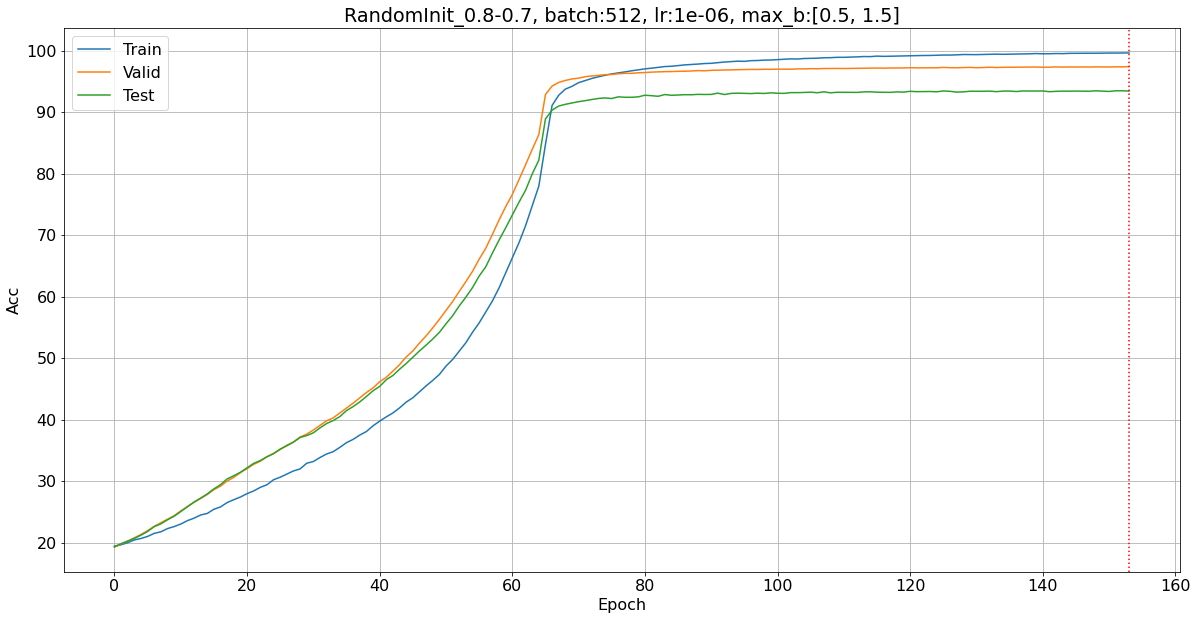

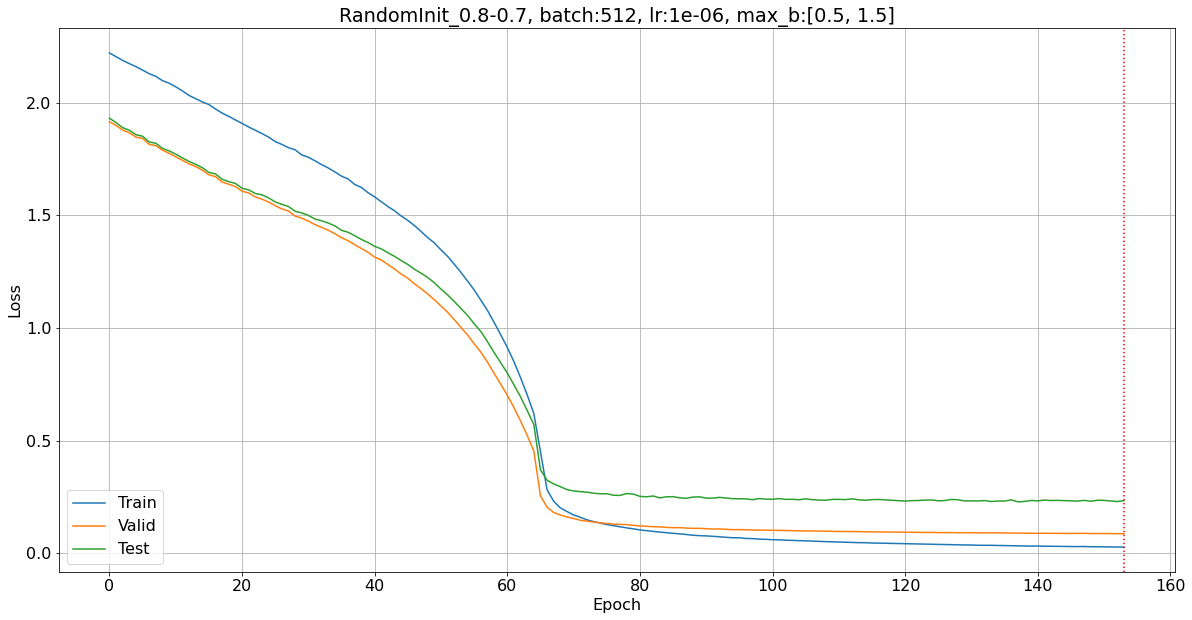

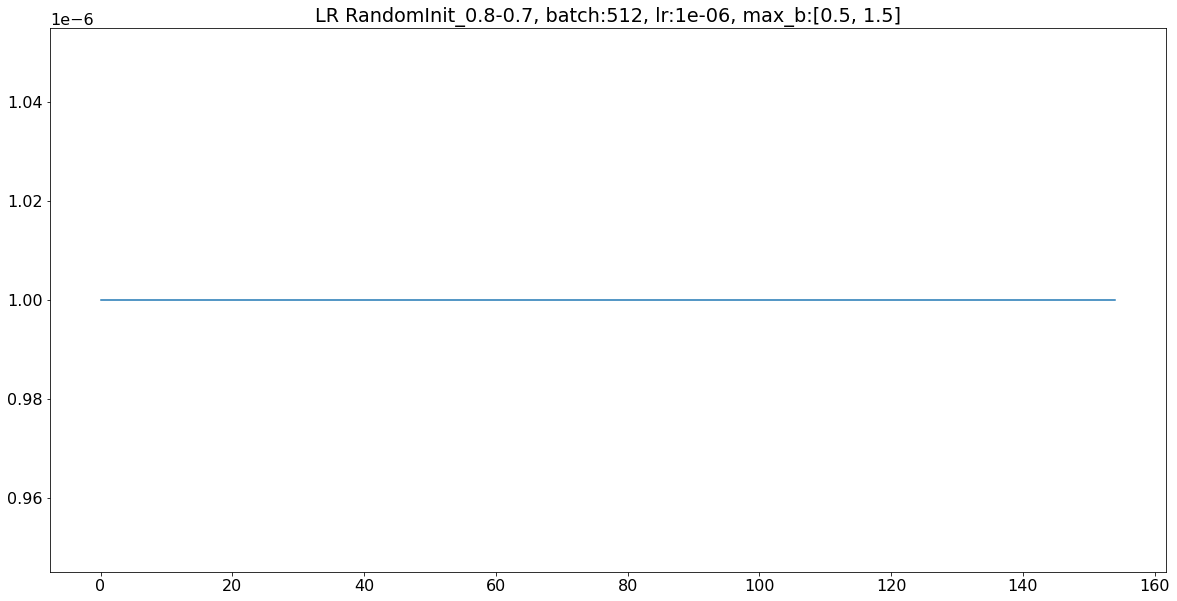

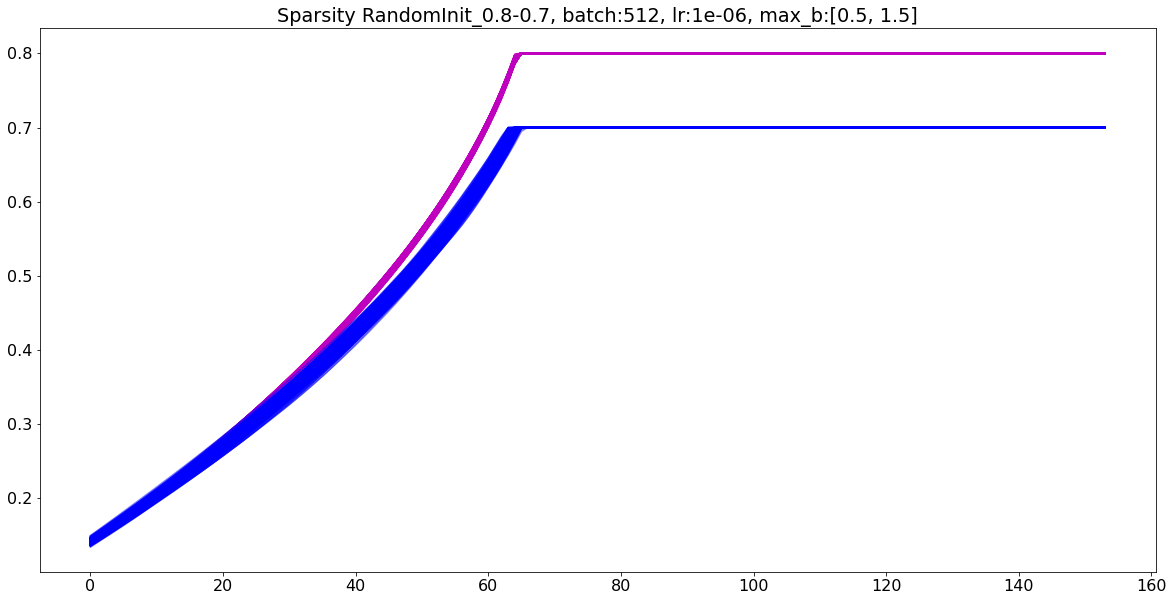

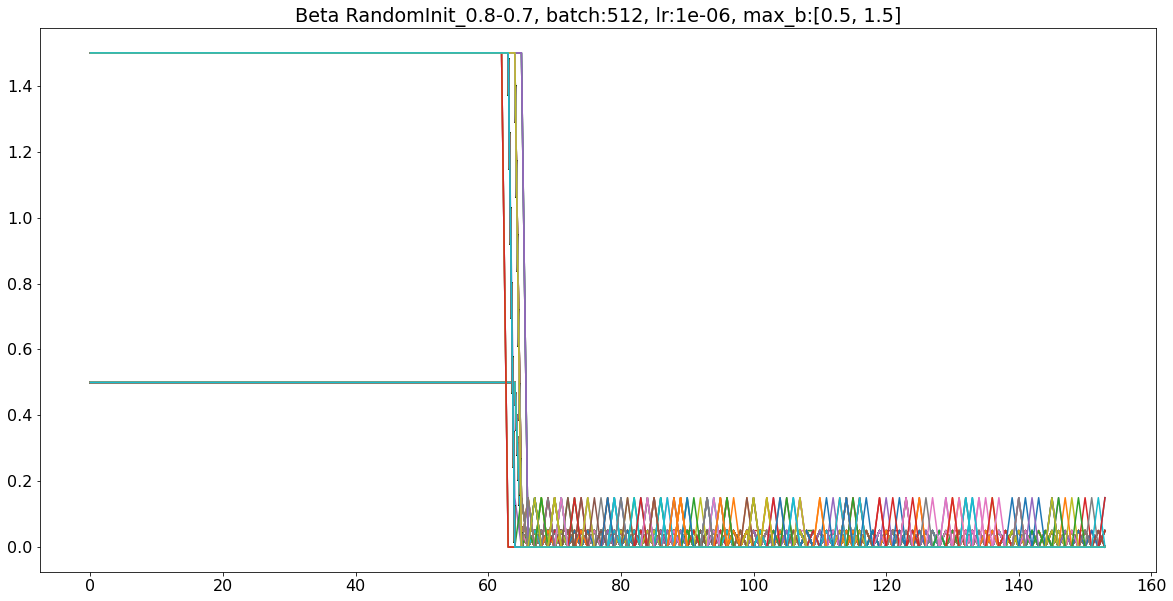

In [327]:
#Sample plot
#학습을 중간에 끊었을 때 (다음 fold로 넘어가지 않았을 때), 현재 fold의 결과를 확인합니다.

def sample_plot(model,save_lr_path):
    
    #몇 epoch까지 확인하고 싶은지 이곳에서 설정합니다. 
    epoch_debug = len(outer_test_acc)
    
    
#     if not os.path.isdir('/users/hjd/hsp_results/{}/plots/{}'.format(config['task_list'][config['target_task']],
#                                                                      model)):
#         os.mkdir('/users/hjd/hsp_results/{}/plots/{}'.format(config['task_list'][config['target_task']],
#                                                              model))
    os.chdir(save_lr_path)
    plt.figure(figsize=(20,10))
    plt.title(model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                          config['learning_rate'],
                                                          config['hsc']['max_b']))
    plt.plot(outer_train_acc)
    plt.plot(outer_valid_acc)
    plt.plot(outer_test_acc)
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(['Train','Valid','Test'])
    plt.axvline(x = outer_valid_loss.index(min(outer_valid_loss)), c = 'r',
               linestyle = 'dotted')
    plt.grid()
#     plt.show()
    plt.savefig(model+"_ACC_"+save_lr_path.split("/")[-1]+".png")
    
    plt.figure(figsize=(20,10))
    plt.title(model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                          config['learning_rate'],
                                                          config['hsc']['max_b']))
    plt.plot(outer_train_loss)
    plt.plot(outer_valid_loss)
    plt.plot(outer_test_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Valid','Test'])
    plt.axvline(x = outer_valid_loss.index(min(outer_valid_loss)), c = 'r',
               linestyle = 'dotted')
    plt.grid()
#     plt.show()
    plt.savefig(model+"_Loss_"+save_lr_path.split("/")[-1]+".png")
    
    plt.figure(figsize=(20,10))
    plt.title('LR '+model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                          config['learning_rate'],
                                                          config['hsc']['max_b'])) 
    plt.plot(outer_lr_list)
    plt.savefig(model+"_LR_"+save_lr_path.split("/")[-1]+".png")   
    
    #Sparsity
    node_sp1 = []
    node_sp2 = []
    for j in range(5000):
        node = []
        for i in range(epoch_debug):
            node.append(hsp_list[i][0][j]) #make list of each node's epochs
        node_sp1.append(node)
    for j in range(config['comb']['comb_num'][1]):
        node = []
        for i in range(epoch_debug):
            node.append(hsp_list[i][1][j]) #make list of each node's epochs
        node_sp2.append(node)    

    plt.figure(figsize=(20,10))
    plt.title('Sparsity ' +model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                          config['learning_rate'],
                                                          config['hsc']['max_b']))    
    for i in range(5000):
        plt.plot(node_sp1[i], color = 'm', alpha = 0.5)
    for i in range(config['comb']['comb_num'][1]):
        plt.plot(node_sp2[i], color = 'b', alpha = 0.5)
#     plt.show()
    plt.savefig(model+"_Sparsity_"+save_lr_path.split("/")[-1]+".png")
    
    #Beta
    node_sp1 = []
    node_sp2 = []
    for j in range(5000):
        node = []
        for i in range(epoch_debug):
            node.append(beta_list[i][0][j]) #make list of each node's epochs
        node_sp1.append(node)
    for j in range(config['comb']['comb_num'][1]):
        node = []
        for i in range(epoch_debug):
            node.append(beta_list[i][1][j]) #make list of each node's epochs
        node_sp2.append(node)    

    plt.figure(figsize=(20,10))
    plt.title('Beta ' +model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                          config['learning_rate'],
                                                          config['hsc']['max_b']))    

    for i in range(5000):
        plt.plot(node_sp1[i])
    for i in range(config['comb']['comb_num'][1]):
        plt.plot(node_sp2[i])
#     plt.show()
    
    plt.savefig(model+"_Beta_"+save_lr_path.split("/")[-1]+".png")

sample_plot('{}_{}-{}'.format(p_model[0],tg_hsp[0],tg_hsp[1]),save_lr_path)
    

In [103]:
hsp1 = [folds_hsp_list1[0]] #,folds_hsp_list1[1]]
hsp2 = [folds_hsp_list2[0]] #,folds_hsp_list2[1]]
beta1 = [folds_beta_list1[0]] #, folds_beta_list1[1]]
beta2 = [folds_beta_list2[0]] #, folds_beta_list2[1]]

#Check each node's sparsity

node_sp1 = []
node_sp2 = []

for k in range(len(hsp1)):
    fold_node_1 = []
    for j in range(5000):
        node = []
        for i in range(len(hsp1[k])):
            node.append(hsp1[k][i][j]) #make list of each node's epochs
        fold_node_1.append(node)
    node_sp1.append(fold_node_1)
    
for k in range(len(hsp2)):
    fold_node_2 = []
    for j in range(50):
        node = []
        for i in range(len(hsp2[k])):
            node.append(hsp2[k][i][j]) #make list of each node's epochs
        fold_node_2.append(node)
    node_sp2.append(fold_node_2)

    
#Check each node's beta

node_b1 = []
node_b2 = []

for k in range(len(beta1)):
    fold_node_1 = []
    for j in range(5000):
        node = []
        for i in range(len(beta1[k])):
            node.append(beta1[k][i][j]) #make list of each node's epochs
        fold_node_1.append(node)
    node_b1.append(fold_node_1)
    
for k in range(len(beta2)):
    fold_node_2 = []
    for j in range(50):
        node = []
        for i in range(len(beta2[k])):
            node.append(beta2[k][i][j]) #make list of each node's epochs
        fold_node_2.append(node)
    node_b2.append(fold_node_2)

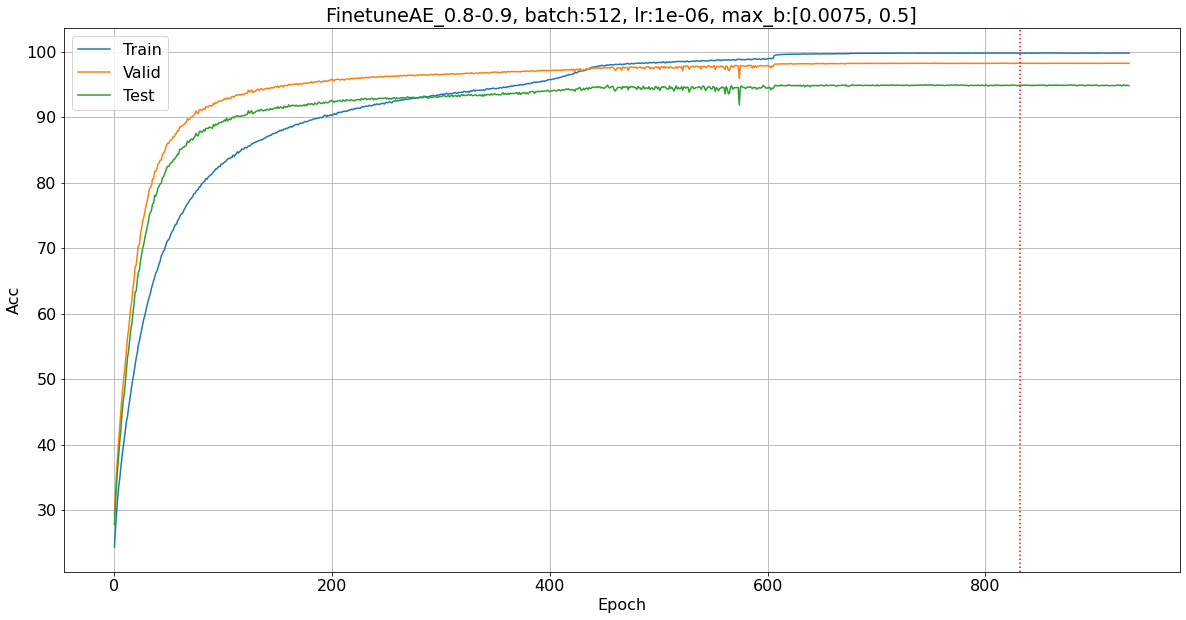

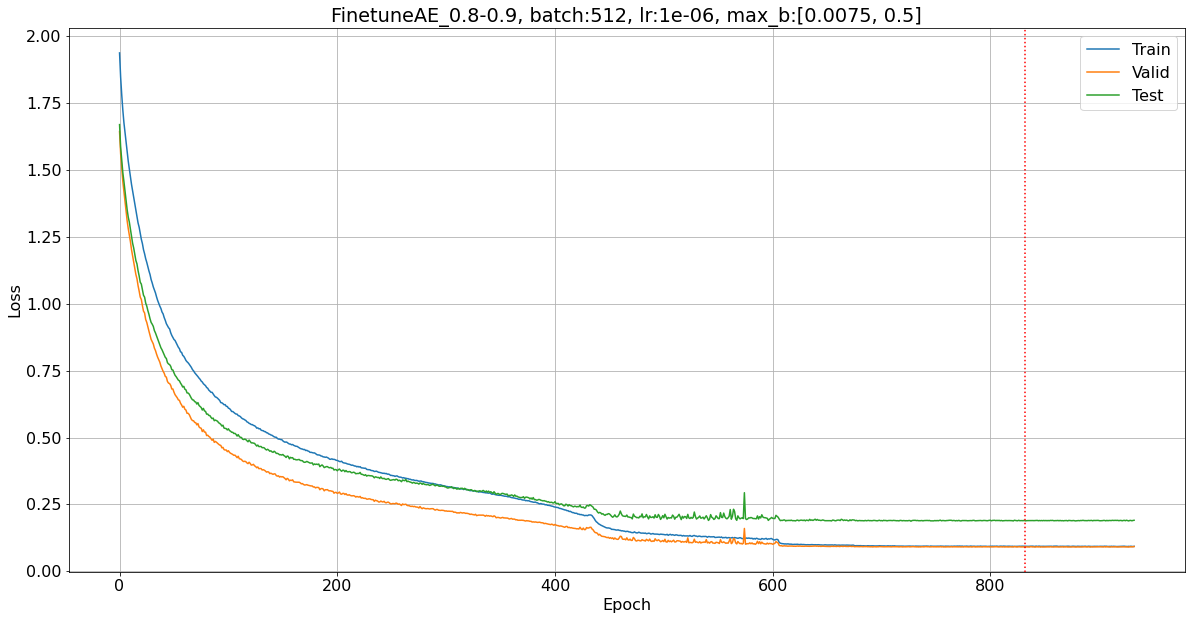

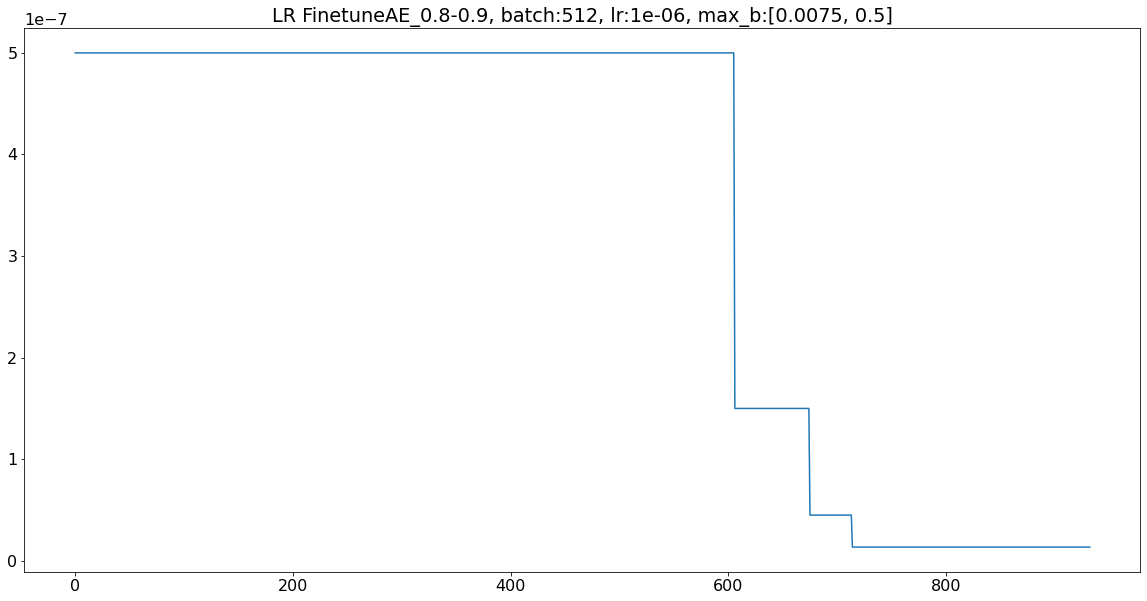

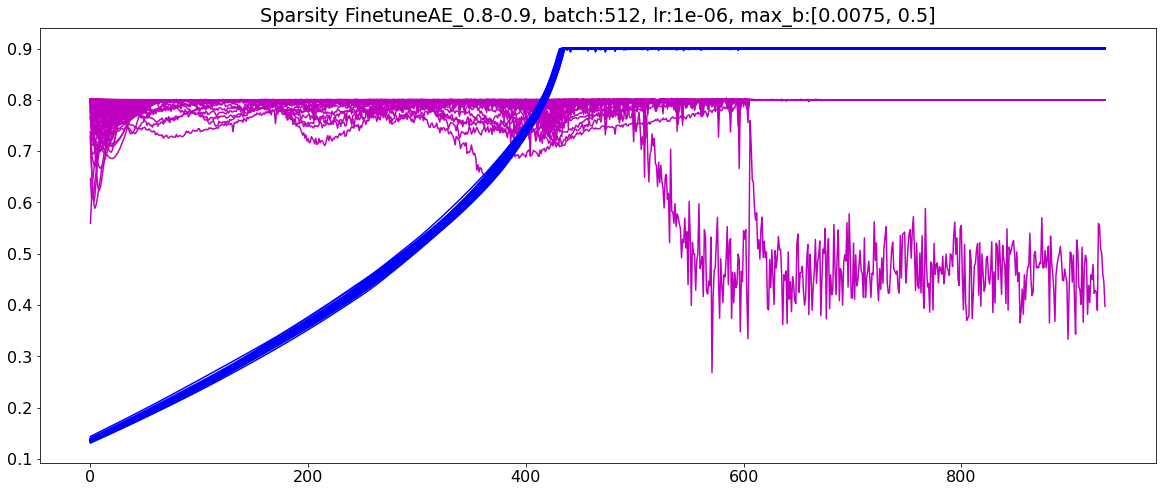

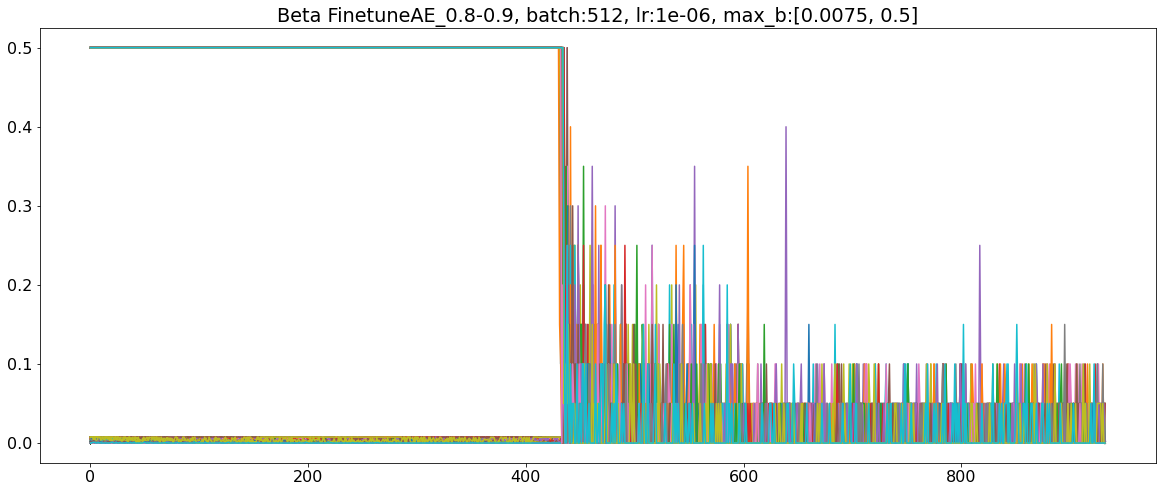

In [104]:
model='{}_{}-{}'.format(p_model[0],tg_hsp[0],tg_hsp[1])


if not os.path.isdir('/users/hjd/hsp_results/{}/plots/{}'.format(config['task_list'][config['target_task']],model)):
    os.mkdir('/users/hjd/hsp_results/{}/plots/{}'.format(config['task_list'][config['target_task']],model))
os.chdir('/users/hjd/hsp_results/{}/plots/{}'.format(config['task_list'][config['target_task']],model))
plt.figure(figsize=(20,10))
plt.title(model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                      config['learning_rate'],
                                                      config['hsc']['max_b']))
plt.plot(folds_train_acc[0])
plt.plot(folds_valid_acc[0])
plt.plot(folds_test_acc[0])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Train','Valid','Test'])
plt.axvline(x = folds_valid_loss[0].index(min(folds_valid_loss[0])), c = 'r',
           linestyle = 'dotted')
plt.grid()
#     plt.show()
plt.savefig('Acc, batch:{}, lr:{}, max_b:{}.png'.format(config['batch_size'],
                                                         config['learning_rate'],
                                                        config['hsc']['max_b']))

plt.figure(figsize=(20,10))
plt.title(model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                      config['learning_rate'],
                                                      config['hsc']['max_b']))
plt.plot(folds_train_loss[0])
plt.plot(folds_valid_loss[0])
plt.plot(folds_test_loss[0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid','Test'])
plt.axvline(x = folds_valid_loss[0].index(min(folds_valid_loss[0])), c = 'r',
           linestyle = 'dotted')
plt.grid()
#     plt.show()
plt.savefig('Loss, batch:{}, lr:{}, max_b:{}.png'.format(config['batch_size'],
                                                         config['learning_rate'],
                                                        config['hsc']['max_b']))   
plt.figure(figsize=(20,10))
plt.title('LR '+model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                      config['learning_rate'],
                                                      config['hsc']['max_b'])) 
plt.plot(folds_lr_list[0])
plt.savefig('Learning rate, batch:{}, lr:{}, max_b:{}.png'.format(config['batch_size'],
                                                         config['learning_rate'],
                                                        config['hsc']['max_b']))    


for k in range(len(node_sp1)):
    plt.figure(figsize=(20,8))
#     plt.title('{} sparsity - Fold {}'.format(model_name.split(sep='/')[-2],k+1))
    for i in range(len(node_sp1[k])):
        plt.plot(node_sp1[k][i], c = 'm')
    for i in range(len(node_sp2[k])):
        plt.plot(node_sp2[k][i], c = 'b')
#     plt.show()

plt.title('Sparsity ' +model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                  config['learning_rate'],
                                                  config['hsc']['max_b']))    

plt.savefig('Sparsity, batch:{}, lr:{}, max_b:{}.png'.format(config['batch_size'],
                                                         config['learning_rate'],
                                                        config['hsc']['max_b']))

    
for k in range(len(node_b1)):
    plt.figure(figsize=(20,8))
#     plt.title('{} beta - Fold {}'.format(model_name.split(sep='/')[-2],k+1))
    for i in range(len(node_b1[k])):
        plt.plot(node_b1[k][i])
    for i in range(len(node_b2[k])):
        plt.plot(node_b2[k][i])
#     plt.show()

plt.title('Beta ' +model+ ', batch:{}, lr:{}, max_b:{}'.format(config['batch_size'],
                                                          config['learning_rate'],
                                                          config['hsc']['max_b']))    

plt.savefig('Beta, batch:{}, lr:{}, max_b:{}.png'.format(config['batch_size'],config['learning_rate'],config['hsc']['max_b']))




In [75]:
np.savez('/users/hjd/hsp_results/MOTOR/plots/FinetuneAE_5000_50_2.npz',
         train = folds_train_acc[0], valid = folds_valid_acc[0],
         test = folds_test_acc[0], lr = folds_lr_list[0],
        hsp1 = folds_hsp_list1[0], hsp2 = folds_hsp_list2[0],
        b1 = folds_beta_list1[0], b2 = folds_beta_list2[0])

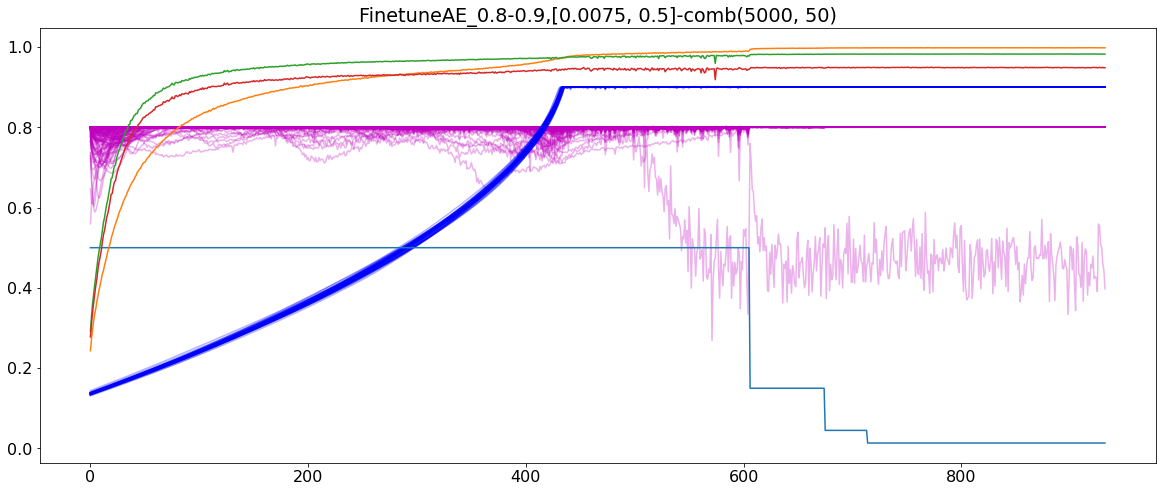

In [92]:
for k in range(len(node_sp1)):
    plt.figure(figsize=(20,8))
    plt.title('{}-comb{}'.format(save_lr_path.split(sep='/')[-1],config['comb']['comb_num']))
    for i in range(len(node_sp1[k])):
        plt.plot(node_sp1[k][i], c = 'm', alpha = 0.3, label='hsp1')
    for i in range(len(node_sp2[k])):
        plt.plot(node_sp2[k][i], c = 'b', alpha = 0.3, label='hsp2')
    plt.plot(np.array(folds_lr_list[k])*(10**6))

    plt.plot(np.array(folds_train_acc[k])*0.01)
    plt.plot(np.array(folds_valid_acc[k])*0.01)
    plt.plot(np.array(folds_test_acc[k])*0.01)
    
    plt.savefig()                                                                                   config['learning_rate'],
                                                                                                      config['hsc']['max_b'])))
#     plt.show()